In [4]:
from photonic_planar_code import *
from graph_operations import *
from visualization import *

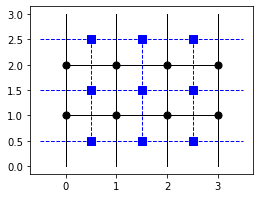

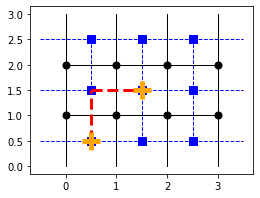

In [5]:
code = PhotonicPlanarCode(L=4)
lattice = code.dual
plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=True)
# lattice.apply_edge_operators([(0,2,0), (2,1,0), (3,1,0), (2,0,0)])
lattice.apply_z1z2((2,1), (1,0))
plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=True)
syndrome = lattice.measure_syndrome(debug=True)
# plot_matchings(lattice, syndrome, pathfinding='manhattan')
# plot_matchings(lattice, syndrome, pathfinding='djikstra')

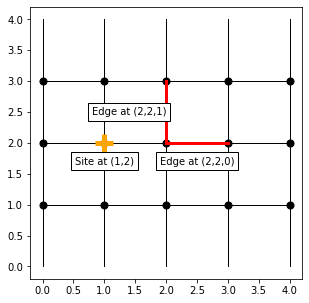

In [11]:
L, W = (5, 5)
pz=0
px=0
rz=0.05
rx=0.05

code = PhotonicPlanarCode(L, W)
shape = code.primal.shape
fig, ax = plt.subplots(
    1, 1, figsize=[
    asymptotic_length_scale(i) for i in shape]
)
ax.set_aspect('equal')
ax.grid(False)
code.primal.edges[2,2,0] = True
code.primal.edges[2,2,1] = True
plot_lattice(ax, code.primal, show_errors=True, show_syndrome=False)
ax.scatter(1,2,**PRIMAL_SYNDROME)
ax.text(1,1.7,"Site at (1,2)",bbox=dict(facecolor='white', edgecolor='black'),ha='center',va='center')
ax.text(2,2.5,"Edge at (2,2,1)",bbox=dict(facecolor='white', edgecolor='black'),ha='right',va='center')
ax.text(2.5,1.7,"Edge at (2,2,0)",bbox=dict(facecolor='white', edgecolor='black'),ha='center',va='center')
plt.savefig('temp/lattice_coords.pdf', bbox_inches='tight')

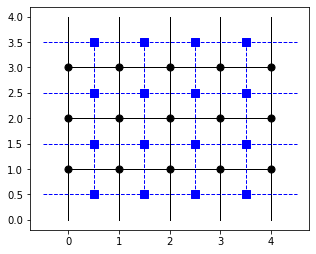

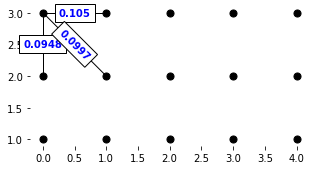

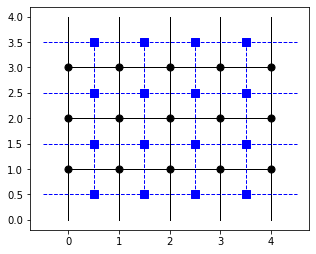

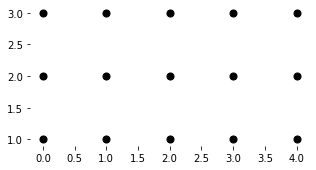

In [4]:
code = PhotonicPlanarCode(L, W, pz=pz, px=px, rz=rz, rx=rx)
plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=True)
failed = np.zeros(code.dual.shape, dtype=bool)
failed[1,2] = True
code.measure_syndrome(lattice=1, failed_sites=failed)
plot_error_probabilities(code.primal)
plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=True)
code.primal.reset_error_model()
plot_error_probabilities(code.primal)

In [5]:
key = (0,1,1)
CorrelatedPlanarLattice.dump_error(code.primal.heralded_p, key, 0.5)
code.primal.heralded_p[key]

0.5

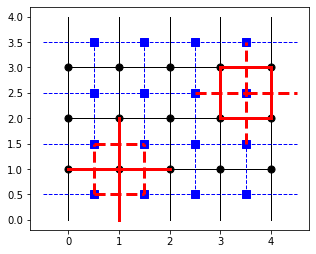

In [10]:
code.reset()

site = (1,1)
x, y = site
z = [(x, y, 1), (x, y, 0), (x, y-1, 1), (x-1, y, 0)]
dual_z = [code.primal_to_dual(c) for c in z]
for coords in z:
    code.primal.edges[coords] = True
for dual_coords in dual_z:
    code.dual.edges[dual_coords] = True
    
site = (4,2)
x, y = site
z = [(x, y, 1), (x, y, 0), (x, y-1, 1), (x-1, y, 0)]
dual_z = [code.primal_to_dual(c, reverse=True) for c in z]
for coords in z:
    code.dual.edges[coords] = True
for dual_coords in dual_z:
    code.primal.edges[dual_coords] = True

plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=False, save_as='temp/dump_errors.pdf')

In [ ]:
lattice = CorrelatedPlanarLattice(r=0.15, L=5, W=5, boundaries=np.array([1, 0], dtype=bool), p=0.05)
s0 = (1,2)
s1 = (2,1)
lattice.correlated_syndrome_p[(s0, s1)] = 0.5
lattice.apply_z1z2(s0, s1)
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.grid(False)
plot_lattice(ax, lattice)

In [ ]:
plot_matchings(lattice, lattice.measure_syndrome(debug=True))

In [ ]:
import itertools
from tqdm.auto import tqdm

code = PhotonicPlanarCode(L=8, W=8)
lattice = code.primal
L, W, D = lattice.edges.shape
edges = itertools.product(range(L), range(W), range(D))
max_len_3_errors = itertools.combinations(edges, r=3)

bad_error_chains = []
for errors in tqdm(max_len_3_errors):
    code.reset()
    for edge in errors:
        lattice.apply_edge_operator(edge)
    syndrome = lattice.measure_syndrome(debug=True)
    matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='manhattan')
    for path in paths:
        lattice.apply_edge_operators(path)
    logical_errors = lattice.detect_logical_errors()
    if logical_errors > 0:
        bad_error_chains.append(errors)

In [ ]:
print(bad_error_chains)

In [ ]:
code = PhotonicPlanarCode(L=6, W=6, rz=0.3)
lattice = code.primal
L, W, D = lattice.edges.shape
sites = itertools.product(range(L), range(W))
max_len_2_errors = itertools.combinations(sites, r=3)

valid_len_2_errors = []
for chain in tqdm(max_len_2_errors):
    invalid = False
    prev = chain[0]
    for curr in chain[1:]:
        abs_deltas = np.abs(np.array(curr) - np.array(prev))
        invalid = np.any(abs_deltas > 1)
        if invalid:
            break
    if not invalid:
        valid_len_2_errors.append(tuple(chain))

bad_error_chains = []
for errors in tqdm(valid_len_2_errors):
    code.reset()
    lattice._apply_edge_operators_sites(errors, update_herald_p=False)
    syndrome = lattice.measure_syndrome(debug=True)
    matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='manhattan')
    for path in paths:
        lattice.apply_edge_operators(path)
    logical_errors = lattice.detect_logical_errors()
    if logical_errors > 0:
        bad_error_chains.append(errors)

In [ ]:
print(bad_error_chains)

In [ ]:
# check some math

import sympy as sy

r, a, b, c, d = sy.symbols('r a b c d')
p0 = 1-(1-r)**5
q1 = r*(1-r)/(2*p0)
q12 = q1*(1-r)
q4 = q12*(1-r)
M0 = (1-(q1+q12+q4))*a + q1*b + q12*c + q4*d
M0_factors = ((1-q1)*a + q1*b) * ((1-q12)*a + q1*c) * ((1-q4)*a + q4*d)

sy.factor(M0)

In [ ]:
sy.expand(M0_factors)